In [1328]:
import math
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [1329]:
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
            )
crime_df = pd.read_csv(data_path, header=1, index_col=False, skiprows=[0, 1, 2])
crime_df = crime_df.drop(crime_df.index[-3:])

#Clean up the column names
crime_df.columns=['City','Population', 'Violent crime', 'Murder', 'Rape revised', 'Rape legacy', 'Robbery', 
         'Aggravated assault','Property crime', 'Burglary', 'Larceny', 'Motor vehicle theft', 'Arson']
crime_df.tail(10)

,City,Population,Violent crime,Murder,Rape revised,Rape legacy,Robbery,Aggravated assault,Property crime,Burglary,Larceny,Motor vehicle theft,Arson
338,West Seneca Town,"44,821",35,1.000,nan,1,9,24,896,166,710,20,0.000
339,Whitehall Village,"2,604",6,0.000,nan,0,0,6,62,12,49,1,nan
340,White Plains,"57,559",78,1.000,nan,3,28,46,"1,232",77,"1,134",21,nan
341,Whitesboro Village,"3,733",4,0.000,nan,0,0,4,36,14,21,1,0.000
342,Whitestown Town,"9,141",0,0.000,nan,0,0,0,77,13,61,3,0.000
343,Woodbury Town,"10,685",3,0.000,nan,0,2,1,541,9,529,3,nan
344,Woodridge Village,829,7,0.000,nan,0,0,7,17,8,9,0,0.000
345,Woodstock Town,"5,931",2,0.000,nan,0,0,2,58,13,45,0,nan
346,Yonkers,"199,134","1,036",6.000,nan,25,390,615,"2,368",470,"1,662",236,10.000
347,Yorktown Town,"36,643",15,0.000,nan,0,2,13,334,45,287,2,nan


In [1330]:
#Turn the Population strings into integers
crime_df['Population'] = crime_df['Population'].str.replace(',', '')
crime_df['Population'] = crime_df['Population'].astype(int)
#Turn the Robbery strings into integers
crime_df['Robbery'] = crime_df['Robbery'].str.replace(',', '')
crime_df['Robbery'] = crime_df['Robbery'].astype(int)
#Turn the Violent crime strings into integers
crime_df['Violent crime'] = crime_df['Violent crime'].str.replace(',', '')
crime_df['Violent crime'] = crime_df['Violent crime'].astype(int)
#Turn the Aggravated Assault strings into integers
crime_df['Aggravated assault'] = crime_df['Aggravated assault'].str.replace(',', '')
crime_df['Aggravated assault'] = crime_df['Aggravated assault'].astype(int)
#Turn the Property crime strings into integers
crime_df['Property crime'] = crime_df['Property crime'].str.replace(',', '')
crime_df['Property crime'] = crime_df['Property crime'].astype(int)
#Turn the Burglary strings into integers
crime_df['Burglary'] = crime_df['Burglary'].str.replace(',', '')
crime_df['Burglary'] = crime_df['Burglary'].astype(int)
#Turn the Larceny strings into integers
crime_df['Larceny'] = crime_df['Larceny'].str.replace(',', '')
crime_df['Larceny'] = crime_df['Larceny'].astype(int)
#Turn the Motor vehicle theft strings into integers
crime_df['Motor vehicle theft'] = crime_df['Motor vehicle theft'].str.replace(',', '')
crime_df['Motor vehicle theft'] = crime_df['Motor vehicle theft'].astype(int)

#Combine the Rape Scenarios into one category
crime_df['Rape legacy'] = crime_df['Rape legacy'].str.replace(',', '')
crime_df['Rape legacy'] = crime_df['Rape legacy'].astype(int)
crime_df['Rape revised'] = crime_df['Rape revised'].replace([None], 0).astype(int)
crime_df['Rape legacy'] = crime_df['Rape legacy'].replace([None], 0)
crime_df['Rape combined'] = crime_df['Rape revised'] + crime_df['Rape legacy']

crime_df['Arson'] = crime_df['Arson'].replace([None], 0).astype(int)

#Make Murder and Robbery binary
threshold = 1
crime_df['Property crime binary'] = np.where(crime_df['Property crime'] >= threshold, 1,0)
crime_df['Murder binary'] = np.where(crime_df['Murder'] >= threshold, 1,0)
crime_df['Robbery binary'] = np.where(crime_df['Robbery'] >= threshold, 1, 0)

crime_df.head(10)

,City,Population,Violent crime,Murder,Rape revised,Rape legacy,Robbery,Aggravated assault,Property crime,Burglary,Larceny,Motor vehicle theft,Arson,Rape combined,Property crime binary,Murder binary,Robbery binary
0,Adams Village,1861,0,0.000,0,0,0,0,12,2,10,0,0,0,1,0,0
1,Addison Town and Village,2577,3,0.000,0,0,0,3,24,3,20,1,0,0,1,0,0
2,Akron Village,2846,3,0.000,0,0,0,3,16,1,15,0,0,0,1,0,0
3,Albany,97956,791,8.000,0,30,227,526,4090,705,3243,142,0,30,1,1,1
4,Albion Village,6388,23,0.000,0,3,4,16,223,53,165,5,0,3,1,0,1
5,Alfred Village,4089,5,0.000,0,0,3,2,46,10,36,0,0,0,1,0,1
6,Allegany Village,1781,3,0.000,0,0,0,3,10,0,10,0,0,0,1,0,0
7,Amherst Town,118296,107,1.000,0,7,31,68,2118,204,1882,32,3,7,1,1,1
8,Amityville Village,9519,9,0.000,0,2,4,3,210,16,188,6,1,2,1,0,1
9,Amsterdam,18182,30,0.000,0,0,12,18,405,99,291,15,0,0,1,0,1


In [1331]:
#Double Check there is no missing data

def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
print(crime_df.apply(num_missing, axis=0))

Missing values per column:
City                     0
Population               0
Violent crime            0
Murder                   0
Rape revised             0
Rape legacy              0
Robbery                  0
Aggravated assault       0
Property crime           0
Burglary                 0
Larceny                  0
Motor vehicle theft      0
Arson                    0
Rape combined            0
Property crime binary    0
Murder binary            0
Robbery binary           0
dtype: int64


In [1332]:
#look at data for outliers
print(crime_df.describe())

       Population  Violent crime  Murder  Rape revised  Rape legacy   Robbery  \
count     348.000        348.000 348.000       348.000      348.000   348.000   
mean    40037.632        201.595   1.566         0.000        5.865    72.902   
std    450037.368       2815.269  18.304         0.000       60.425  1031.033   
min       526.000          0.000   0.000         0.000        0.000     0.000   
25%      3003.000          2.000   0.000         0.000        0.000     0.000   
50%      7233.500          6.000   0.000         0.000        0.000     1.000   
75%     18427.500         22.000   0.000         0.000        2.000     5.000   
max   8396126.000      52384.000 335.000         0.000     1112.000 19170.000   

       Aggravated assault  Property crime  Burglary    Larceny  \
count             348.000         348.000   348.000    348.000   
mean              121.261         792.606   119.684    637.017   
std              1706.132        7659.725   924.949   6346.054   
min   

In [1333]:
#Let's Remove New York since it far outnumbers other data
crime_df = crime_df[crime_df.City != 'New York']

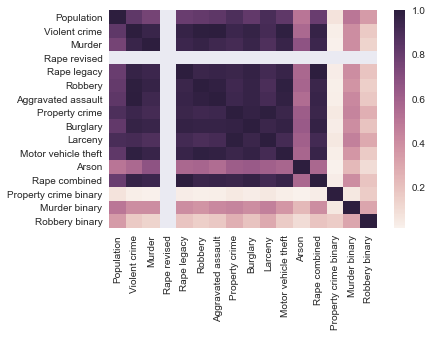

In [1334]:
# Take a look at the relationship between the variables

sns.heatmap(crime_df.corr())

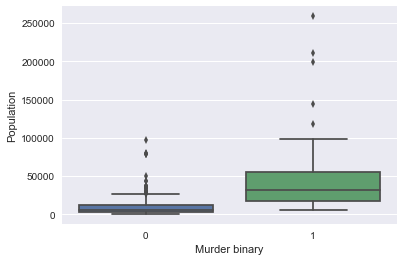

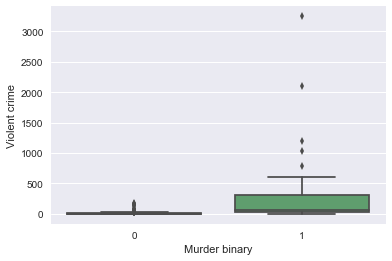

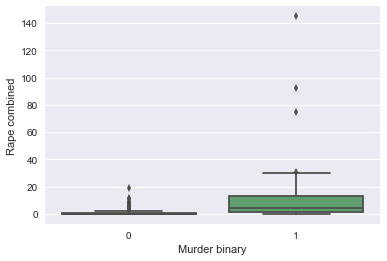

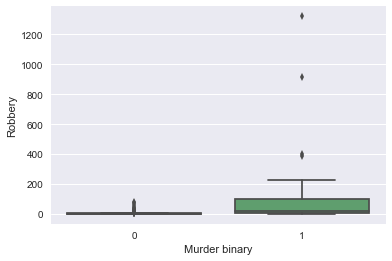

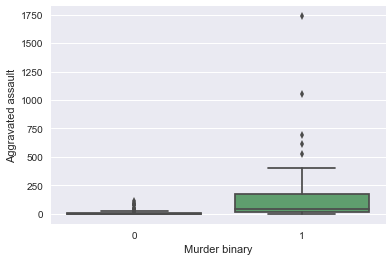

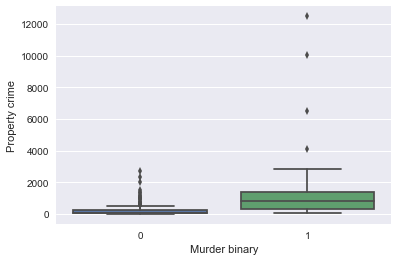

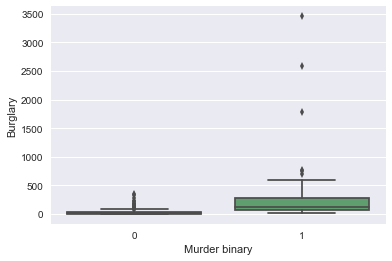

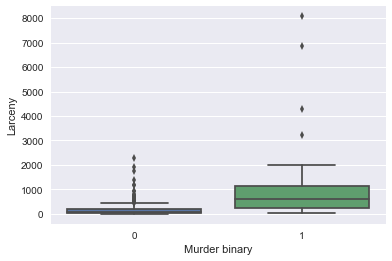

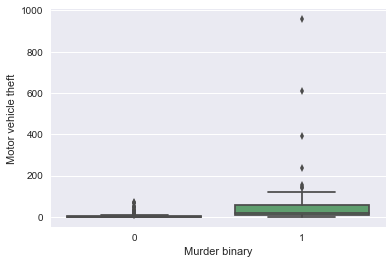

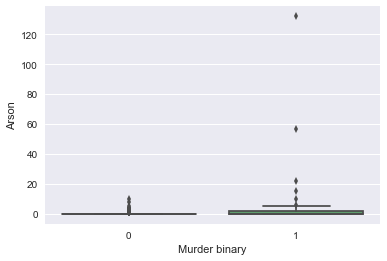

In [1335]:
# Take a look at the relationship between the dependent variable and the independent variable in box plots since this is a binary variable

sns.boxplot(y="Population", x='Murder binary', data=crime_df)
plt.show()
sns.boxplot(y="Violent crime", x='Murder binary', data=crime_df)
plt.show()
sns.boxplot(y="Rape combined", x='Murder binary', data=crime_df)
plt.show()
sns.boxplot(y="Robbery", x='Murder binary', data=crime_df)
plt.show()
sns.boxplot(y="Aggravated assault", x='Murder binary', data=crime_df)
plt.show()
sns.boxplot(y="Property crime", x='Murder binary', data=crime_df)
plt.show()
sns.boxplot(y="Burglary", x='Murder binary', data=crime_df)
plt.show()
sns.boxplot(y="Larceny", x='Murder binary', data=crime_df)
plt.show()
sns.boxplot(y="Motor vehicle theft", x='Murder binary', data=crime_df)
plt.show()
sns.boxplot(y="Arson", x='Murder binary', data=crime_df)
plt.show()


In [1336]:
# randomly create our training and test samples
msk = np.random.rand(len(crime_df)) < 0.8
train = crime_df[msk]
test = crime_df[~msk]
Y_train = train['Murder binary']
Y_test = test['Property crime binary']
X_train = train.drop(['Murder binary', 'City', 'Murder'], axis=1)

In [1337]:
X, y = X_train, Y_train


In [1338]:
# Declare a logistic regression classifier.

lr = LogisticRegression(C=9e9)

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

print('\n Percentage accuracy')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=10))

Coefficients
[[  6.06195501e-06   9.72078080e+00   0.00000000e+00  -4.83235755e+00
   -9.73373673e+00  -9.71484352e+00   2.32327656e-04   4.21522004e-03
    5.68756265e-05  -4.03976800e-03  -1.64158251e-01  -4.83235755e+00
   -3.29812123e+00   2.28952960e+00]]
[-5.18809254]

 Percentage accuracy
1.0
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [1339]:
# Now with pentaly 'l1' which is Lasso
lr = LogisticRegression(C=1, penalty='l1')

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

print('\n Percentage accuracy')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))

Coefficients
[[  1.68620130e-05   4.22510409e+00   0.00000000e+00  -2.05239052e+00
   -4.23623908e+00  -4.21759085e+00   6.61193583e-05   5.70305328e-03
    3.16369897e-05  -1.56205966e-02   0.00000000e+00  -2.04978532e+00
    0.00000000e+00   0.00000000e+00]]
[-4.21197708]

 Percentage accuracy
1.0
[ 0.96153846  0.98076923  1.          0.96153846  0.94117647]


Computing regularization path ...


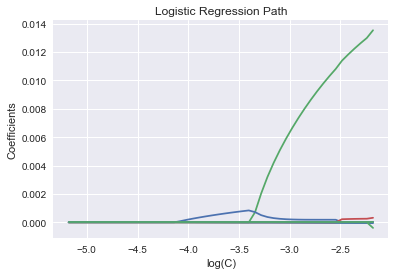

In [1340]:
cs = l1_min_c(X, y, loss='log') * np.logspace(0, 3)


print("Computing regularization path ...")

clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())


coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

In [1341]:
# Now with pentaly 'l2' penalty which is Ridge
lr = LogisticRegression(C=1, penalty='l2')

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

print('\n Percentage accuracy')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))

Coefficients
[[  1.72253173e-05   2.38801876e+00   0.00000000e+00  -1.13151871e+00
   -2.39712233e+00  -2.37906168e+00  -4.03457769e-03   9.75282615e-03
    4.19340377e-03  -1.79808076e-02   2.80480451e-02  -1.13151871e+00
   -1.77904747e+00   6.04447842e-01]]
[-2.23598469]

 Percentage accuracy
0.972972972973
[ 0.96153846  0.94230769  0.94230769  0.96153846  0.90196078]


Computing regularization path ...


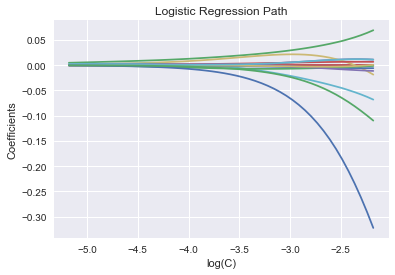

In [1342]:
cs = l1_min_c(X, y, loss='log') * np.logspace(0, 3)


print("Computing regularization path ...")

clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())


coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

In [1343]:
#Let's pick variables that are fairly independent of each other that provide a high R-Squared
# These variables were the ones used in the Linear regression with the continuous variable

# Instantiate and fit our model.
lr = LogisticRegression(C=9e9)
X = X_train[['Population', 'Property crime binary', 'Robbery']]
lr.fit(X, y)


# Inspect the results.
print('\nCoefficients: \n', lr.coef_)
print('\nIntercept: \n', lr.intercept_)
print('\nR-squared:')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))


Coefficients: 
 [[  4.69382009e-05  -7.36405663e-01   3.18078337e-02]]

Intercept: 
 [-2.54899589]

R-squared:
0.911196911197
[ 0.92307692  0.86538462  0.94230769  0.86538462  0.96078431]


In [1344]:
#Take a look at it with Lasso Regression
lr = LogisticRegression(C=1, penalty='l1')

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

print('\n Percentage accuracy')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))

Coefficients
[[  4.43667542e-05   0.00000000e+00   3.16283525e-02]]
[-3.178437]

 Percentage accuracy
0.911196911197
[ 0.92307692  0.86538462  0.94230769  0.86538462  0.96078431]


In [1345]:
#Now take a look at it with Ridge Regression
lr = LogisticRegression(C=1, penalty='l2')

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

print('\n Percentage accuracy')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))

Coefficients
[[  4.28663507e-05  -1.23178736e+00   3.18001238e-02]]
[-1.89162677]

 Percentage accuracy
0.911196911197
[ 0.92307692  0.86538462  0.94230769  0.86538462  0.96078431]


In [1346]:
#That's still giving a high R2, so let's do feature selection using SK Learn
#First, let's reset X to X_train
X = X_train
rfe = RFE(lr,n_features_to_select=2) 
fit = rfe.fit(X,y)
result_RFE = pd.DataFrame(list(zip(X.head(0), rfe.ranking_, rfe.support_)),
                          columns=['Features','Ranking','Support'] ) 
print(result_RFE.sort_values('Ranking'))


                 Features  Ranking  Support
1           Violent crime        1     True
5      Aggravated assault        1     True
4                 Robbery        2    False
11          Rape combined        3    False
12  Property crime binary        4    False
3             Rape legacy        5    False
13         Robbery binary        6    False
10                  Arson        7    False
9     Motor vehicle theft        8    False
7                Burglary        9    False
8                 Larceny       10    False
6          Property crime       11    False
0              Population       12    False
2            Rape revised       13    False


In [1347]:
#Let's pop those into the model
lr = LogisticRegression(C=9e9)
X = X_train[['Violent crime', 'Aggravated assault']]
lr.fit(X, y)


# Inspect the results.
print('\nCoefficients: \n', lr.coef_)
print('\nIntercept: \n', lr.intercept_)
print('\nR-squared:')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))


Coefficients: 
 [[ 0.02512772  0.01623534]]

Intercept: 
 [-3.11486761]

R-squared:
0.915057915058
[ 0.94230769  0.90384615  0.92307692  0.88461538  0.92156863]


In [1348]:
#Let's pop those into the Lasso Model
lr = LogisticRegression(C=1, penalty='l1')

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

print('\n Percentage accuracy')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))

Coefficients
[[ 0.02527884  0.01358007]]
[-3.01415233]

 Percentage accuracy
0.915057915058
[ 0.94230769  0.90384615  0.92307692  0.88461538  0.92156863]


In [1349]:
#Let's pop those into the Ridge model
lr = LogisticRegression(C=1, penalty='l2')

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

print('\n Percentage accuracy')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))

Coefficients
[[ 0.02437233  0.01121294]]
[-2.84811297]

 Percentage accuracy
0.915057915058
[ 0.94230769  0.88461538  0.92307692  0.88461538  0.92156863]


In [1350]:
#Our answers are still coming out too high so let's play with our Lambda.

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Ridge and Lasso are the same value when rounded to 3 decimal point at the following values for R2: []
Which is the following lambda values: []


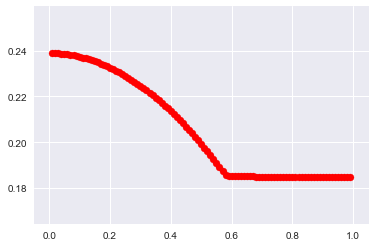

In [1351]:
numb = np.arange(0.01, 1, 0.01)
yl = []
yr = []
for g in numb:
    lassBig = linear_model.Lasso(alpha=g)
    lassBig.fit(X, Y_train)
    i = lassBig.score(X, Y_train)
    yl.append(i)

for g in numb:
    ridgeregrBig = linear_model.Ridge(alpha=g, fit_intercept=False)
    ridgeregrBig.fit(X, Y_train)
    i = ridgeregrBig.score(X, Y_train)
    yr.append(i)
samelr = []
samelambda = []
numb2 = np.arange(0, len(yl), 1)
for p in numb2:
    if round(yl[p], 3) == round(yr[p], 3):
        samelr.append(yl[p])
        samelambda.append(numb[p])

print('Ridge and Lasso are the same value when rounded to 3 decimal point at the following values for R2: {}'.format(samelr))
print('Which is the following lambda values: {}'.format(samelambda))
    
plt.scatter(numb, yl, c='r')

plt.show()

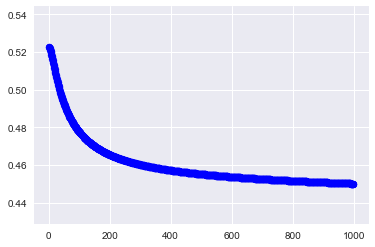

In [1352]:
numb = np.arange(1, 1000, 1)

yr2 = []

for g in numb:
    ridgeregrBig = linear_model.Ridge(alpha=g, fit_intercept=False)
    ridgeregrBig.fit(X_train, Y_train)
    i = ridgeregrBig.score(X_train, Y_train)
    yr2.append(i)
    
plt.scatter(numb, yr2, c='b')

plt.show()

In [1353]:
#Let's pop those into the Ridge model
lr = LogisticRegression(C=0.5, penalty='l1')

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

print('\n Percentage accuracy')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))

Coefficients
[[ 0.02542576  0.01106143]]
[-2.91876478]

 Percentage accuracy
0.915057915058
[ 0.94230769  0.90384615  0.92307692  0.88461538  0.92156863]


In [1354]:
#Let's pop those into the Ridge model
lr = LogisticRegression(C=180, penalty='l2')

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

print('\n Percentage accuracy')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))

Coefficients
[[ 0.02512212  0.01620279]]
[-3.11309022]

 Percentage accuracy
0.915057915058
[ 0.94230769  0.90384615  0.92307692  0.88461538  0.92156863]


In [1355]:
#Still not coming up with anything good. Let's try PCA with the whole training set and see if we can just pull out variance we need without the noise.
lr = LogisticRegression(C=9e9)
X = X_train

pca = PCA(n_components=3)
X_std_pca = pca.fit_transform(X)
X1 = pd.DataFrame(X_std_pca)
fit = lr.fit(X1, y)
print(lr.score(X1, y))
print(cross_val_score(lr, X1, y, cv=5))

0.903474903475
[ 0.94230769  0.86538462  0.94230769  0.88461538  0.88235294]


In [1356]:
#Let's try PCA with Lasso
lr = LogisticRegression(C=1, penalty='l1')
X = X_train

pca = PCA(n_components=3)
X_std_pca = pca.fit_transform(X)
X1 = pd.DataFrame(X_std_pca)
fit = lr.fit(X1, y)
print(lr.score(X1, y))
print(cross_val_score(lr, X1, y, cv=5))

0.895752895753
[ 0.92307692  0.84615385  0.94230769  0.86538462  0.88235294]


In [1357]:
#Let's try PCA with Ridge
lr = LogisticRegression(C=1, penalty='l2')
X = X_train

pca = PCA(n_components=3)
X_std_pca = pca.fit_transform(X)
X1 = pd.DataFrame(X_std_pca)
fit = lr.fit(X1, y)
print(lr.score(X1, y))
print(cross_val_score(lr, X1, y, cv=5))

0.903474903475
[ 0.94230769  0.86538462  0.94230769  0.88461538  0.88235294]


This is a particularly hard data set to work with because each of the features on their own can give very high R2 values. I used Vanilla logistic regression, Lasso logistic regression, and Ridge logistic regression to find a model that got rid of the noise and focused on the signal, but had difficulties due to the data set. The best values came after applying Principle Component Analysis to the model though each method still gave roughly the same R2 values.